## Time Series Forecasting using Recurrent Neural Networks (RNN) in TensorFlow

In [1]:
#!pip install graphviz
#!pip install pydot
#!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [3]:
ticker = 'MSFT'
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
data = data['Close'].values.reshape(-1, 1)

/tmp/ipython-input-2225860266.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [4]:
data

array([[152.50570679],
       [150.60671997],
       [150.9960022 ],
       ...,
       [427.37728882],
       [421.71905518],
       [418.41345215]])

## Normalizing the Data

Normalizing data between 0 and 1 prevents large values from dominating smaller ones making training more efficient, improving model stability and convergence especially for deep learning models.

MinMaxScaler: is used to normalize the stock price data to a range between 0 and 1.
scaler.fit_transform(data): Fits the scaler to the dataset and scales all values accordingly.

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
scaled_data[:10]

array([[0.0707035 ],
       [0.06500846],
       [0.06617591],
       [0.06204713],
       [0.06919431],
       [0.0748893 ],
       [0.07275373],
       [0.07827772],
       [0.0750032 ],
       [0.07799304]])

## Preparing the Data for Time Series

We will create a function to create a dataset for the training of our RNN model.

create_dataset is a function that generates the input data (X) and target data (y). It slides a window of length time_step (60) over the stock prices and stores the next price as the target.
The X array is reshaped into a 3D array as required by the SimpleRNN layer: [samples, time steps, features]

In [7]:
def create_dataset(data, time_step=4):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [8]:
X, y = create_dataset(scaled_data)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [9]:
X.shape, y.shape

((1253, 4, 1), (1253,))

## Splitting the Data into Training and Testing Sets

We will split the data into training and testing part into the ratio of 80% Training and 20% Testing data

In [10]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Building the RNN Model

The model which we are using here is a Recurrent Neural Network (RNN). It is used for sequential data modeling such as time series forecasting.

The model is built using SimpleRNN layers.
units=50 defines the number of units (neurons) in each RNN layer.
return_sequences=True in the first RNN layer ensures that the output is fed to the next RNN layer.
Dense(units=1) is the output layer, predicting a single value i.e the next stock price.
The model is compiled using the Adam optimizer and Mean Squared Error loss function.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping


In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [13]:
model = Sequential()
# 1st RNN layer (returns full sequence)
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# 2nd RNN layer (returns full sequence)
model.add(SimpleRNN(units=40, return_sequences=True))
# 2nd RNN layer (returns full sequence) with Regularization
# model.add(SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

# 3rd RNN layer (returns only last hidden state)
model.add(SimpleRNN(units=30, return_sequences=False))
model.add(Dense(units=1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
from tensorflow.keras.utils import plot_model


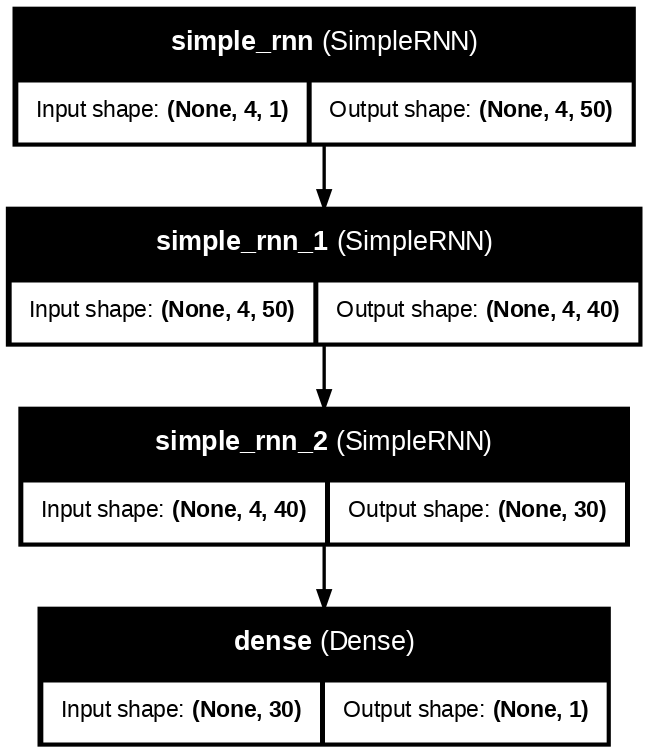

In [15]:
plot_model(
    model,
    to_file="rnn_model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=120
)

In [16]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 4, 50)          │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 4, 40)          │         3,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 30)             │         2,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401 (32.82 KB)

 Trainable params: 8,401 (32.82 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

The model is trained on historical data and used for making predictions.

model.fit(X_train, y_train, epochs=20, batch_size=64): Trains the model for 20 epochs using batches of 64 samples at a time.
model.predict(X_test): Generates predictions for the test data.
scaler.inverse_transform(predictions): Converts the predicted values back to the original scale since they were normalized earlier using MinMaxScaler.

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(
    X_train,
    y_train,
    epochs=50,            # can be large, early stopping will handle it
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)
predictions = model.predict(X_test)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0617 - val_loss: 0.0059
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_loss: 0.0289
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 0.0176
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4191e-04 - val_loss: 0.0067
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2394e-04 - val_loss: 0.0089
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6860e-04 - val_loss: 0.0040
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3037e-04 - val_loss: 0.0041
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7891e-04 - val_loss: 0.0030
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3834e-04 - val_loss: 0.0020
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4121e-04 - val_loss: 0.0024
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4187e-04 - val_loss: 0.0018
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

predictions = model.predict(X_test)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0283 - val_loss: 0.0079
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0823e-04 - val_loss: 0.0051
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0683e-04 - val_loss: 0.0015
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5853e-04 - val_loss: 0.0013
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0688e-04 - val_loss: 9.5263e-04
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2428e-04 - val_loss: 0.0010
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0326e-04 - val_loss: 0.0011
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5695e-04 - val_loss: 7.0206e-04
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2167e-04 - val_loss: 6.0707e-04
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1035e-04 - val_loss: 4.8822e-04
Epoch 12/20


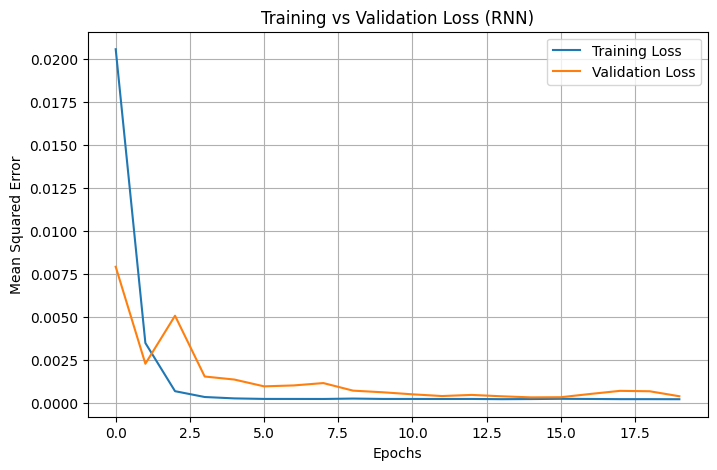

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


## Evaluating the model

The model’s performance is evaluated using standard error metrics. These metrics provide insights into how well the model's predictions align with actual values.

y_test_unscaled: We will use y_test unscaled data to get accurate results.
mean_squared_error(y_test, predictions): Computes the Mean Squared Error (MSE) which measures the average squared difference between actual and predicted values.
np.sqrt(mse): Computes the Root Mean Squared Error (RMSE) which provides error in the same units as the target variable.
mean_absolute_error(y_test, predictions): Computes the Mean Absolute Error (MAE) which measures the average absolute difference between actual and predicted values.

In [20]:
predictions = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_unscaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, predictions)

print(f"Unscaled Mean Squared Error (MSE): {mse}")
print(f"Unscaled Root Mean Squared Error (RMSE): {rmse}")
print(f"Unscaled Mean Absolute Error (MAE): {mae}")

Unscaled Mean Squared Error (MSE): 41.72318153105957
Unscaled Root Mean Squared Error (RMSE): 6.459348382852529
Unscaled Mean Absolute Error (MAE): 5.177058246506162


## Visualizing the Results

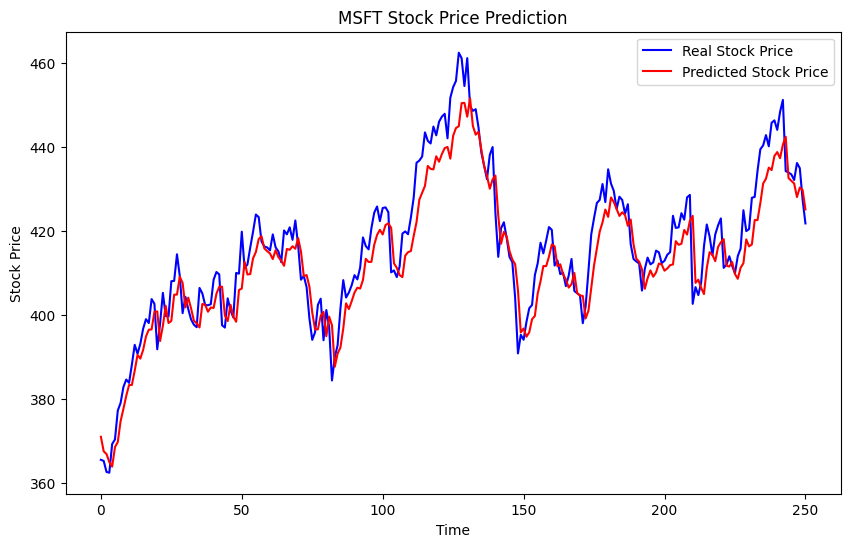

In [21]:
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Real Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Exercise:

1. Change the ticker from AAPL to: MSFT, GOOGL
2. Modify the time_step = 1, 5, 10, 30
3. Questions: How does increasing time_step affect:
    Model complexity?
   Training time?
6. Which time_step gives the lowest validation loss?
7. Experiment with the number of layers
   1 RNN layer
   2 RNN layers
   3 RNN layers

11. Does deeper always mean better?

12. Where do you observe diminishing returns?

13. Change number of neurons: [20, 40, 80]
    
Effect on training loss?    
Effect on validation loss?
